In [ ]:
!unzip '/content/Sara_dataset.zip -d my_data

In [ ]:
# Install the gdown library
!pip install gdown

In [2]:


# Import necessary libraries
import gdown
import zipfile
import os

# Define the Google Drive file ID
file_id = '1tpmNC_yT-vJm-1ihUabi6sEhXhTBZtD2'

# Define the destination directory
extracted_dir = '/content/drive_content'

# Create the destination directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# Define the URL to download the file
url = f'https://drive.google.com/uc?id={file_id}'

# Download the file
output_file = os.path.join(extracted_dir, 'data.zip')
gdown.download(url, output_file, quiet=False)

# Extract the zip file
with zipfile.ZipFile(output_file, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# List all files in the extracted directory
extracted_files = os.listdir(extracted_dir)
print("List of extracted files:")
for file in extracted_files:
    print(file)


Downloading...
From: https://drive.google.com/uc?id=1tpmNC_yT-vJm-1ihUabi6sEhXhTBZtD2
To: /content/drive_content/data.zip
100%|██████████| 4.76M/4.76M [00:00<00:00, 23.2MB/s]

List of extracted files:
data.zip
content


In [4]:
pip install transformers

In [14]:
import os
import re
import pandas as pd
import torch
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel

# Function to load and preprocess a single CSV file
def load_and_preprocess_csv(file_path):
    df = pd.read_csv(file_path)
    # Assuming the dataframe has columns Gyroscope X, Gyroscope Y, Gyroscope Z, Accelerometer X, Accelerometer Y, Accelerometer Z
    # Extract the relevant features from the dataframe
    features = df[['Gyroscope X', 'Gyroscope Y', 'Gyroscope Z', 'Accelerometer X', 'Accelerometer Y', 'Accelerometer Z']]
    # Convert the features to a PyTorch tensor
    features_tensor = torch.tensor(features.values, dtype=torch.float32)
    return features_tensor

# Function to extract class label from file name
def extract_class_label(file_name):
    # Assuming the class label is what comes before 'index' in the file name
    match = re.search(r'([^/]+)\s+index', file_name)
    if match:
        return match.group(1)
    else:
        return None

# Function to train the time series transformer model for classification
def train_time_series_classification_model(train_file_paths, config, num_epochs=5, learning_rate=1e-3):
    # Initialize the model
    model = TimeSeriesTransformerModel(config)

    # Set the model to training mode
    model.train()

    # Define the loss function and optimizer
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Create a mapping between class labels and numerical indices
    class_to_index = {class_label: idx for idx, class_label in enumerate(set([extract_class_label(os.path.basename(file_path)) for file_path in train_file_paths]))}

    # Training loop
    for epoch in range(num_epochs):
        for file_path in train_file_paths:
            # Load and preprocess the CSV file
            features_tensor = load_and_preprocess_csv(file_path)

            # Extract class label from the file name
            class_label = extract_class_label(os.path.basename(file_path))

            if class_label is not None:
                # Convert the class label to a PyTorch tensor
                class_label_tensor = torch.tensor(class_to_index[class_label], dtype=torch.long)

                # Forward pass
                past_time_features = torch.zeros((1, model.config.context_length, model.config.num_features))
                past_time_features = past_time_features.unsqueeze(0).expand(features_tensor.shape[0], -1, -1)
                output = model.forward(past_values=features_tensor.unsqueeze(0), past_time_features=past_time_features, past_observed_mask=None)

                # Compute the loss
                loss = loss_function(output.logits[:, -1, :], class_label_tensor.unsqueeze(0))

                # Backward pass and optimization step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

    return model


# Example usage for training the classification model
# Replace 'content/Sara_dataset/' with the actual path to your dataset
# Example usage for training the classification model
# Replace 'content/Sara_dataset/' with the actual path to your dataset
dataset_path = '/content/drive_content/content/Sara_dataset/'
train_file_paths = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith('.csv')]

# Assuming 6 features for Gyroscope X, Gyroscope Y, Gyroscope Z, Accelerometer X, Accelerometer Y, Accelerometer Z
num_features = 6
configuration = TimeSeriesTransformerConfig(prediction_length=12, num_features=num_features)  # Adjust parameters as needed
trained_model = train_time_series_classification_model(train_file_paths, configuration)



RuntimeError: ignored

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


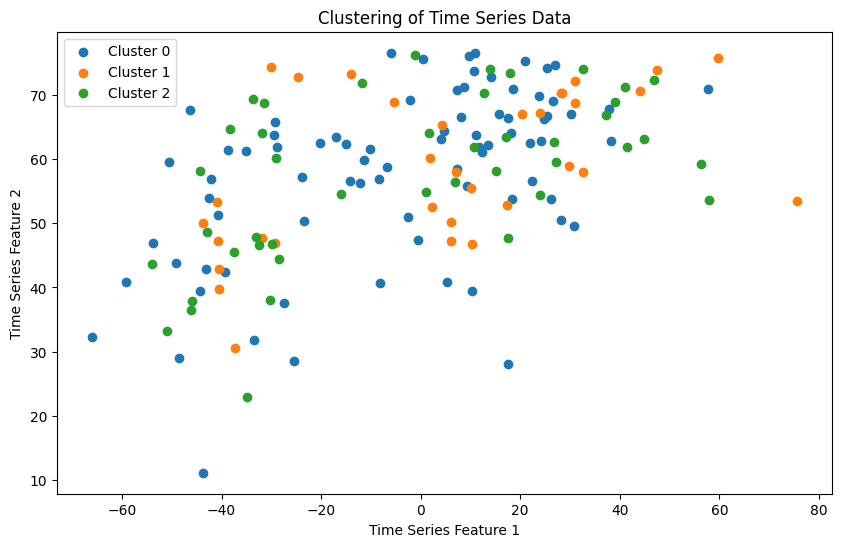

In [20]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Function to load and preprocess a single CSV file
def load_and_preprocess_csv(file_path):
    df = pd.read_csv(file_path)
    # Assuming the dataframe has columns Gyroscope X, Gyroscope Y, Gyroscope Z, Accelerometer X, Accelerometer Y, Accelerometer Z
    # Extract the relevant features from the dataframe
    features = df[['Gyroscope X', 'Gyroscope Y', 'Gyroscope Z', 'Accelerometer X', 'Accelerometer Y', 'Accelerometer Z']]
    # Convert the features to a numpy array
    features_array = features.values
    # Flatten the array (you might want to adjust this based on your specific needs)
    features_flattened = features_array.flatten()
    return features_flattened

# Function to perform unsupervised analysis and visualize clusters
def unsupervised_analysis_and_visualization(file_paths, num_clusters=3):
    # Load and preprocess all CSV files
    all_features = np.vstack([load_and_preprocess_csv(file_path) for file_path in file_paths])

    # Apply clustering using KMeans
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(all_features)

    # Visualize clusters
    plt.figure(figsize=(10, 6))
    for i in range(num_clusters):
        cluster_points = all_features[clusters == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

    # Annotate each point with CSV file name
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        plt.annotate(file_name, (0, 0), textcoords="offset points", xytext=(5, 5), ha='right')

    plt.title('Clustering of Time Series Data')
    plt.xlabel('Time Series Feature 1')
    plt.ylabel('Time Series Feature 2')
    plt.legend()
    plt.show()

# Example usage for unsupervised analysis and visualization
# Replace 'content/Sara_dataset/' with the actual path to your dataset
dataset_path = '/content/drive_content/content/Sara_dataset/'
file_paths = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith('.csv')]

unsupervised_analysis_and_visualization(file_paths)
